In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

/Users/borangoksel/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# kodu tutarlı hale getir
# resultstaki alanları tespit et.
# Bu alanların fotoğraflarını bul
# results'ı yorumla

path = './'
filename = 'joined_nufus.csv' 

df = pd.read_csv(path+filename)

df['area'] = df['area']/1000000
df.head()

,fid,tesis_adi,il_adi,sokak_adi,ilce_adi,mahalle_adi,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus
0,3608,Gönüllü Çay Bahçesi ve Yeşil Alan,İSTANBUL,KALPAZANKAYA YOLU,ADALAR,BURGAZADA,0.001453,7,8,10,1501.0
1,3602,Egemen Bahçe Yeşil Alan,İSTANBUL,BARBAROS HAYRETTİN,ADALAR,BURGAZADA,0.001304,15,8,13,1501.0
2,3603,Sait Faik Abasıyanık Müzesi Önü Park Alanı,İSTANBUL,BARBAROS HAYRETTİN,ADALAR,BURGAZADA,0.000430,6,5,16,1501.0
3,3604,İnönü Parkı (Aynı Zamanda TRANSFER ALANIDIR.),İSTANBUL,ÇAM LİMANI YOLU,ADALAR,HEYBELİADA,0.002634,14,7,7,4025.0
4,3600,Bayraktepe Çocuk Parkı + Top Sahası,İSTANBUL,BUKET,ADALAR,HEYBELİADA,0.000555,1,1,2,4025.0


In [3]:
# Veride null olduğunu biliyoruz. Bu null veriler AFAD'ın mahalleyi yanlış işaretlemesinden kaynaklı. 
df.isnull().sum()

fid                                0
tesis_adi                          0
il_adi                             0
sokak_adi                          0
ilce_adi                           0
mahalle_adi                        0
area                               0
num_of_buildings_between_0_15      0
num_of_buildings_between_15_30     0
num_of_buildings_between_30_50     0
mahalle_nüfus                     24
dtype: int64

<Axes: xlabel='mahalle_nüfus', ylabel='Count'>

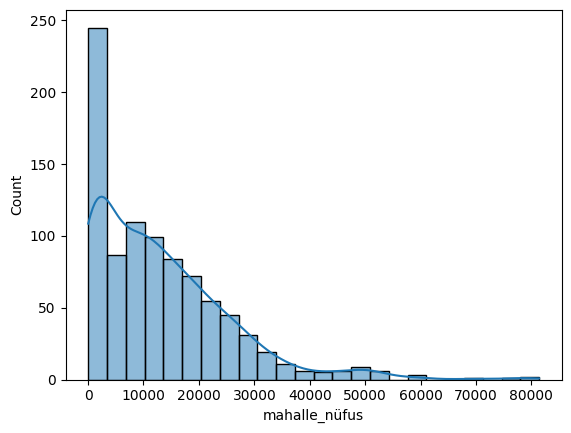

In [4]:
# Mahallelerdeki nüfus histogramı
sns.histplot(data=df[['mahalle_adi','mahalle_nüfus']].drop_duplicates(), x="mahalle_nüfus", kde=True)

In [5]:
df.describe()

,fid,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus
count,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5553.000000
mean,2789.000000,0.008399,6.279720,5.989242,10.251569,20643.960202
std,1610.085557,0.036145,7.370713,7.087653,11.507811,14979.321333
min,1.000000,0.000114,1.000000,0.000000,0.000000,21.000000
25%,1395.000000,0.001348,1.000000,1.000000,1.000000,10211.000000
50%,2789.000000,0.002671,4.000000,4.000000,7.000000,18115.000000
75%,4183.000000,0.005972,9.000000,9.000000,15.000000,26906.000000
max,5577.000000,1.464614,143.000000,65.000000,115.000000,81388.000000


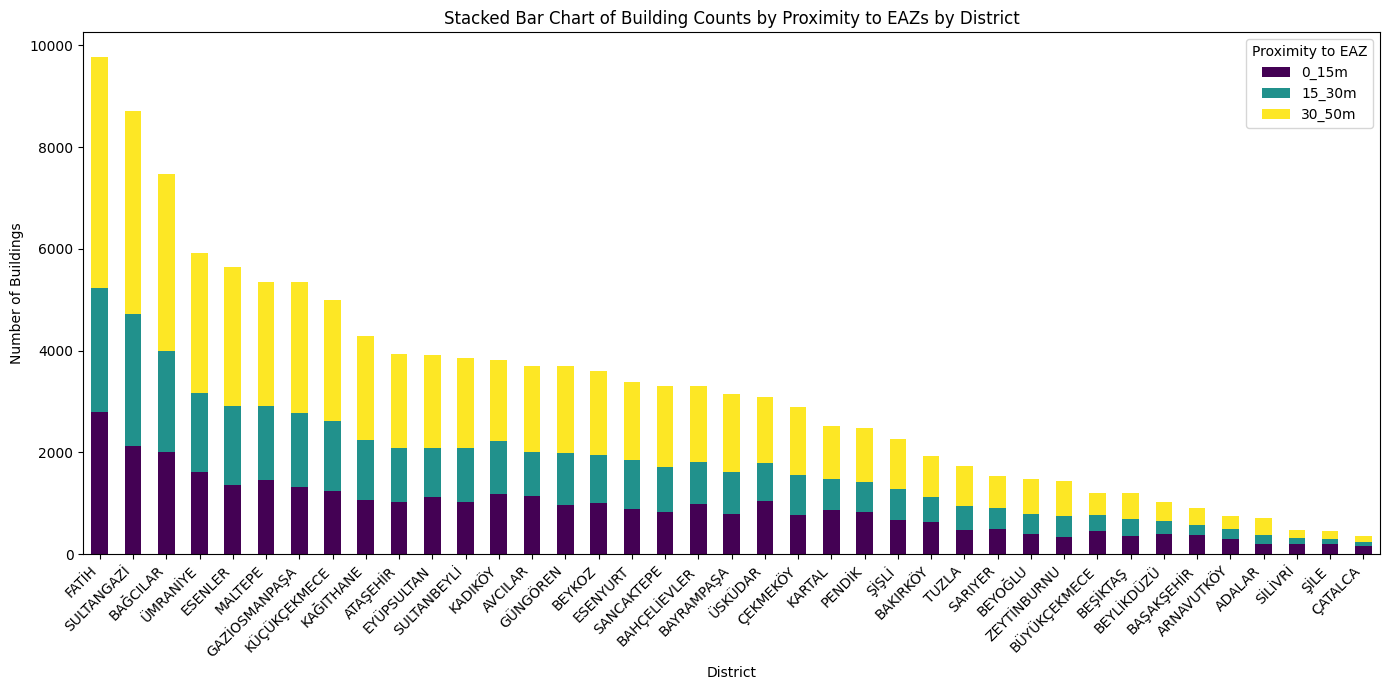

In [6]:
# Burada mahalle bazında bina mesafelerini stacked bar chart halinde çıkartıyoruz.
# Ancak nüfus bina sayısını pozitif yönde etkileyecek. Normalize etmemiz lazım. 
df_building_counts = df[['ilce_adi','num_of_buildings_between_0_15','num_of_buildings_between_15_30','num_of_buildings_between_30_50']]
df_building_counts = df_building_counts.rename(columns={
    'num_of_buildings_between_0_15': '0_15m',
    'num_of_buildings_between_15_30': '15_30m',
    'num_of_buildings_between_30_50': '30_50m',
    'ilce_adi':'District'
})
grouped = df_building_counts.groupby('District')[['0_15m', '15_30m', '30_50m']].sum()

# Optional: sort by total building count (largest first)
grouped['total'] = grouped.sum(axis=1)
grouped = grouped.sort_values(by='total', ascending=False)
grouped.drop(columns='total', inplace=True)

# Plot stacked bar chart
grouped.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='viridis'
)

plt.title("Stacked Bar Chart of Building Counts by Proximity to EAZs by District")
plt.xlabel("District")
plt.ylabel("Number of Buildings")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Proximity to EAZ")
plt.show()

/var/folders/hw/l074dk897h96d7rpk3q148pr0000gn/T/ipykernel_6418/4222845314.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_normalized['total'] = grouped_normalized.sum(axis=1)


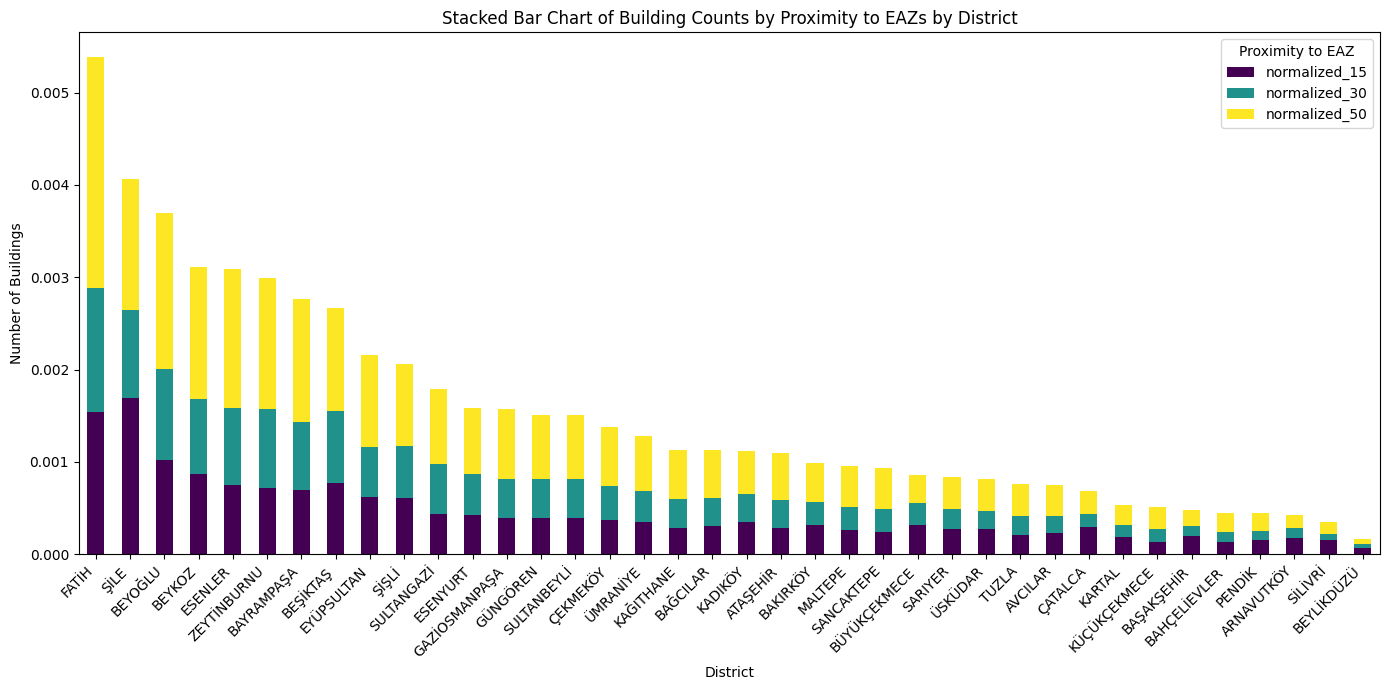

In [7]:
# Mahallelerdeki bina sayılarının nüfusa bölünmüş stacked bar chart'ı
# Bu bar chartın y axis'i bize çok bir şey söylemiyor sadece bar chartları birbirleriyle karşılaştıracağız.
# Aalar'ı exclude ettik çünkü nüfusu düşük ve dar bir alan olduğu için veriyi çarpıtıyordu.
df_building_counts = df[['ilce_adi','num_of_buildings_between_0_15','num_of_buildings_between_15_30','num_of_buildings_between_30_50','mahalle_nüfus']]
df_building_counts = df_building_counts.rename(columns={
    'num_of_buildings_between_0_15': '0_15m',
    'num_of_buildings_between_15_30': '15_30m',
    'num_of_buildings_between_30_50': '30_50m',
    'mahalle_nüfus': 'neg_pop',
    'ilce_adi':'District'
})
df_building_counts = df_building_counts[df_building_counts['District'] != 'ADALAR']

grouped = df_building_counts.groupby('District')[['0_15m', '15_30m', '30_50m','neg_pop']].sum()

grouped['normalized_15'] = grouped['0_15m'] / grouped['neg_pop']
grouped['normalized_30'] = grouped['15_30m'] / grouped['neg_pop']
grouped['normalized_50'] = grouped['30_50m'] / grouped['neg_pop']

grouped_normalized = grouped[['normalized_15','normalized_30','normalized_50']]

# Optional: sort by total building count (largest first)
grouped_normalized['total'] = grouped_normalized.sum(axis=1)
grouped_normalized = grouped_normalized.sort_values(by='total', ascending=False)
grouped_normalized.drop(columns='total', inplace=True)
# Plot stacked bar chart
grouped_normalized.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='viridis'
)

plt.title("Stacked Bar Chart of Building Counts by Proximity to EAZs by District")
plt.xlabel("District")
plt.ylabel("Number of Buildings")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Proximity to EAZ")
plt.show()

In [8]:
# fid'yi dropladık ki model eğitirken kullanmayalım.
df = df.drop(['fid'], axis='columns')
df = df.dropna(axis='index', how='any')

In [9]:
def elbow_method(df, max_k=15,scaler=StandardScaler):
    numeric_cols = [col for col in df.select_dtypes(include='number').columns if col != 'cluster']
    X = df[numeric_cols]
    X_scaled = scaler.fit_transform(X)

    inertia = []
    k_values = range(1, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker='o')
    plt.xticks(k_values)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (WSS)')
    plt.title(f'Elbow Method for Optimal k with {scaler}')
    plt.grid(True)
    plt.show()


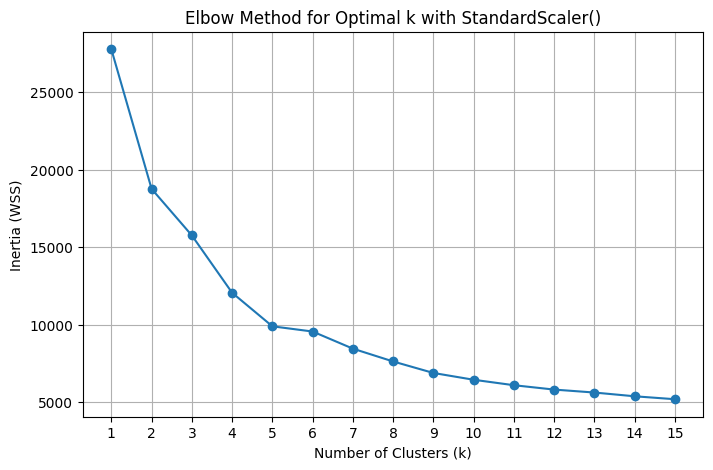

In [10]:
elbow_method(df, max_k=15,scaler=StandardScaler())

In [11]:
def cluster_and_plot(
    df: pd.DataFrame,
    cluster_num: int = 3,
    plot: bool = True,
    scaler=StandardScaler(),
    reduction_method: str = "pca"  # Options: 'pca', 'umap', None
):
    df = df.copy()

    # Select numeric columns (excluding pre-existing cluster)
    numeric_cols = [col for col in df.select_dtypes(include='number').columns if col != 'cluster']
    X = df[numeric_cols]
    X_scaled = scaler.fit_transform(X)

    # Fit KMeans
    kmeans = KMeans(n_clusters=cluster_num, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    df['cluster'] = labels

    # Evaluation
    silhouette = silhouette_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    davies = davies_bouldin_score(X_scaled, labels)

    print("📊 Evaluation Results")
    print(f"Silhouette Score:       {silhouette:.3f}")
    print(f"Calinski-Harabasz Score: {calinski:.1f}")
    print(f"Davies-Bouldin Score:    {davies:.2f}")
    print("\n🔢 Cluster Sizes:")
    print(df['cluster'].value_counts())

    # Plotting
    if plot:
        if reduction_method == "pca":
            X_plot = PCA(n_components=2).fit_transform(X_scaled)
            x_label, y_label = "PCA 1", "PCA 2"
        elif reduction_method == "umap":
            X_plot = UMAP(n_components=2, random_state=42).fit_transform(X_scaled)
            x_label, y_label = "UMAP 1", "UMAP 2"
        else:
            if X_scaled.shape[1] > 2:
                print("❗ Cannot plot high-dimensional data without dimension reduction.")
                return df, kmeans, scaler, numeric_cols
            X_plot = X_scaled
            x_label, y_label = numeric_cols[0], numeric_cols[1]

        plt.figure(figsize=(8, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, cluster_num))
        for cluster_id, color in zip(range(cluster_num), colors):
            cluster_points = X_plot[labels == cluster_id]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                        s=50, color=color, label=f"Cluster {cluster_id}")

        plt.title(f"K-Means Clustering (k={cluster_num}) - {reduction_method.upper() if reduction_method else 'No Reduction'}")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(title="Clusters")
        plt.grid(True)
        plt.show()

    return df, kmeans, scaler, numeric_cols


📊 Evaluation Results
Silhouette Score:       0.373
Calinski-Harabasz Score: 2406.3
Davies-Bouldin Score:    0.97

🔢 Cluster Sizes:
cluster
0    3497
2    1034
1    1011
3      11
Name: count, dtype: int64


/Users/borangoksel/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/borangoksel/.pyenv/versions/3.12.3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


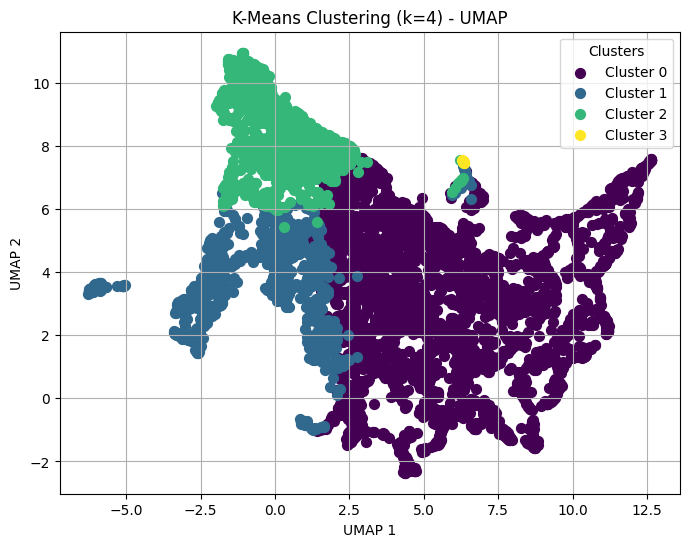

In [12]:
df_clustered, kmeans, scaler, numeric_cols = cluster_and_plot(df,cluster_num=4,plot=True,scaler=StandardScaler(),reduction_method='umap')

In [17]:
pd.set_option('display.max_rows', None)

In [21]:
df_clustered[df_clustered['cluster'] == 3]


,tesis_adi,il_adi,sokak_adi,ilce_adi,mahalle_adi,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus,cluster
967,Florya Atatürk Ormanı,İSTANBUL,ATATÜRK KÖŞKÜ,BAKIRKÖY,BASINKÖY,0.684474,77,35,41,4657.0,3
1065,Sular Vadisi,İSTANBUL,YAŞAR DOĞU,BAŞAKŞEHİR,BAŞAK,0.488048,143,45,115,51601.0,3
1088,Olimpiyat Park Alan ( Aynı Zamanda TRANSFER AL...,İSTANBUL,YAN YOL,BAŞAKŞEHİR,ZİYA GÖKALP,1.464614,41,1,0,22378.0,3
1202,Yıldız Parkı,İSTANBUL,VAPURİSKELESİ,BEŞİKTAŞ,YILDIZ,0.387132,45,26,26,4197.0,3
1986,15 Temmuz Millet Bahçesi ( Aynı Zamanda TRANS...,İSTANBUL,OTOGAR BAĞLANTI YOLU,ESENLER,15 TEMMUZ,0.378596,21,5,5,7800.0,3
2133,Abdullah Gül Parkı ( Aynı Zamanda TRANSFER AL...,İSTANBUL,2247,ESENYURT,GÖKEVLER,0.531539,1,0,1,12223.0,3
2656,Yıldız Teknik Üniversitesi Davutpaşa Kampüsü (...,İSTANBUL,DAVUTPAŞA,GÜNGÖREN,GENÇOSMAN,0.742071,89,58,112,32377.0,3
4707,Sultangazi Hacı Bektaşı Veli Kent Ormanı,İSTANBUL,1469,SULTANGAZİ,ZÜBEYDE HANIM,0.964632,30,41,48,23022.0,3
4709,S.Gazi Mimar Sinan Kent Ormanı,İSTANBUL,1426,SULTANGAZİ,ZÜBEYDE HANIM,0.603999,47,24,17,23022.0,3
5094,Trabzon Park Millet Bahçesi,İSTANBUL,MUŞMULA,ÜMRANİYE,CEMİL MERİÇ,0.448136,37,38,41,16741.0,3


In [ ]:
pd.set_option('display.float_format', '{:.5f}'.format)


In [31]:
#inverse standardized
centroids_unscaled = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=numeric_cols
)
centroids_unscaled.head()


,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus
0,0.00573,3.46163,2.90206,5.12171,14287.18442
1,0.00875,5.45669,5.26378,9.04429,43088.77264
2,0.01002,16.02321,16.76789,28.20019,20080.49903
3,0.64978,49.72727,26.54545,41.09091,18512.18182


In [32]:
df_clustered.groupby('cluster')[numeric_cols].median()


,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus
cluster,,,,,
0,0.00246,2.00000,2.00000,3.00000,14650.00000
1,0.00315,5.00000,5.00000,8.00000,38925.00000
2,0.00309,14.00000,15.00000,26.00000,18491.00000
3,0.53154,41.00000,26.00000,41.00000,16741.00000


In [33]:
df_clustered.groupby('cluster')[numeric_cols].mean()


,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus
cluster,,,,,
0,0.00574,3.46497,2.90678,5.12811,14305.21333
1,0.00875,5.45500,5.25915,9.04154,43168.85262
2,0.01002,16.02321,16.76789,28.20019,20080.49903
3,0.64978,49.72727,26.54545,41.09091,18512.18182


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distributions(df, features, cluster_col='cluster'):
    num_features = len(features)
    num_cols = 2
    num_rows = (num_features + 1) // num_cols

    plt.figure(figsize=(12, 4 * num_rows))
    
    for idx, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, idx + 1)
        sns.boxplot(data=df, x=cluster_col, y=feature, palette='viridis')
        plt.title(f"{feature} by Cluster")
        plt.xlabel("Cluster")
        plt.ylabel(feature)
        plt.grid(True, axis='y')

    plt.tight_layout()
    plt.show()


/var/folders/hw/l074dk897h96d7rpk3q148pr0000gn/T/ipykernel_6418/3720396733.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cluster_col, y=feature, palette='viridis')
/var/folders/hw/l074dk897h96d7rpk3q148pr0000gn/T/ipykernel_6418/3720396733.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cluster_col, y=feature, palette='viridis')
/var/folders/hw/l074dk897h96d7rpk3q148pr0000gn/T/ipykernel_6418/3720396733.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cluster_col, y=feature, palette='viridis')
/

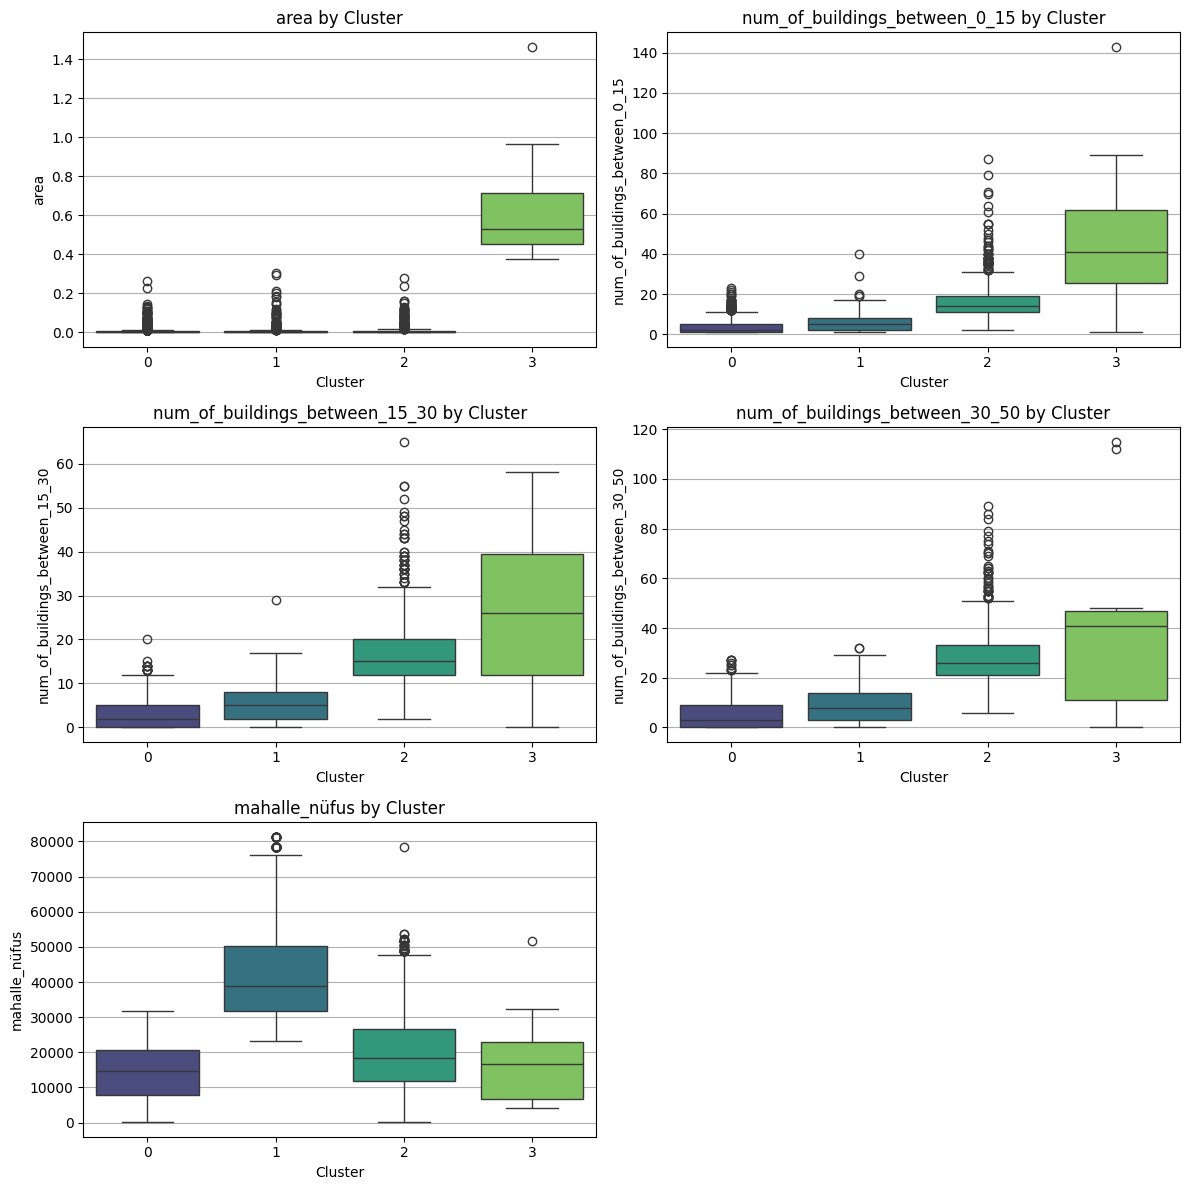

In [14]:
plot_feature_distributions(df_clustered, numeric_cols)

# 📊 Updated Evaluation Results

| Metric           | Your Score | Interpretation                                                                                     |
|------------------|------------|--------------------------------------------------------------------------------------------------|
| Silhouette Score | 0.483      | 🟢 Good separation — close to 0.5, indicating well-defined clusters with decent cohesion.         |
| Calinski-Harabasz| 2906.0     | 🟢 Very strong — confirms the clusters are compact and well-separated.                            |
| Davies-Bouldin   | 0.86       | 🟢 Below 1 — good, indicating low similarity between clusters.                                   |

##### gpt comments

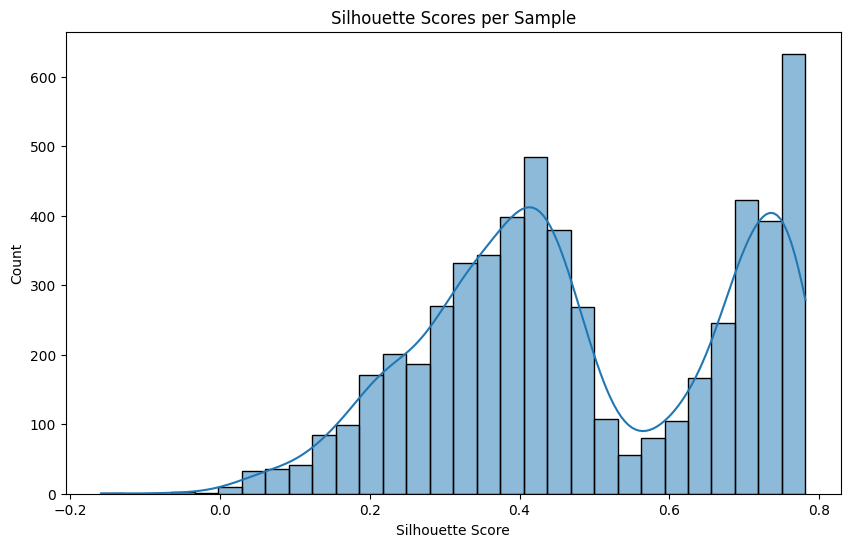

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

sample_silhouette_values = silhouette_samples(X_scaled, df['cluster'])

plt.figure(figsize=(10, 6))
sns.histplot(sample_silhouette_values, bins=30, kde=True)
plt.title("Silhouette Scores per Sample")
plt.xlabel("Silhouette Score")
plt.ylabel("Count")
plt.show()


In [ ]:
df.groupby('cluster')[numeric_cols].mean()


,area,num_of_buildings_between_0_15,num_of_buildings_between_15_30,num_of_buildings_between_30_50,mahalle_nüfus,cluster
cluster,,,,,,
0,5731.874973,1.721913,0.990715,1.720984,13450.692665,0.0
1,10010.591691,16.030829,16.742775,28.186898,20213.182081,1.0
2,7037.531432,5.894043,5.662553,9.901277,27437.532766,2.0
3,649778.502727,49.727273,26.545455,41.090909,18512.181818,3.0


In [22]:
df_clustered.to_csv(path+'df_clustered.csv')